In [155]:
# The question: How many deaths can be predicted by vaccination rates?
# The strategy: regress death rates onto last weeks and the current weeks vaccination rates


library("ggplot2")
library("dplyr")
library("tidyr")
library(MMWRweek)
library(quantreg)
library("lubridate")

In [156]:
# Make a convenience function that transforms state codes to state names

#'x' is the column of a data.frame that holds 2 digit state codes
stateFromLower <-function(x) {
   #read 52 state codes into local variable [includes DC (Washington D.C. and PR (Puerto Rico)]
  st.codes<-data.frame(
                      state=as.factor(c("AK", "AL", "AR", "AZ", "CA", "CO", "CT", "DC", "DE", "FL", "GA",
                                         "HI", "IA", "ID", "IL", "IN", "KS", "KY", "LA", "MA", "MD", "ME",
                                         "MI", "MN", "MO", "MS",  "MT", "NC", "ND", "NE", "NH", "NJ", "NM",
                                         "NV", "NY", "OH", "OK", "OR", "PA", "PR", "RI", "SC", "SD", "TN",
                                         "TX", "UT", "VA", "VT", "WA", "WI", "WV", "WY")),
                      full=as.factor(c("alaska","alabama","arkansas","arizona","california","colorado",
                                       "connecticut","district of columbia","delaware","florida","georgia",
                                       "hawaii","iowa","idaho","illinois","indiana","kansas","kentucky",
                                       "louisiana","massachusetts","maryland","maine","michigan","minnesota",
                                       "missouri","mississippi","montana","north carolina","north dakota",
                                       "nebraska","new hampshire","new jersey","new mexico","nevada",
                                       "new york","ohio","oklahoma","oregon","pennsylvania","puerto rico",
                                       "rhode island","south carolina","south dakota","tennessee","texas",
                                       "utah","virginia","vermont","washington","wisconsin",
                                       "west virginia","wyoming"))
                       )
     #create an nx1 data.frame of state codes from source column
  st.x<-data.frame(state=x)
     #match source codes with codes from 'st.codes' local variable and use to return the full state name
  refac.x<-st.codes$full[match(st.x$state,st.codes$state)]
     #return the full state names in the same order in which they appeared in the original source
  return(refac.x)
 
}

In [157]:
# Read death data. Deaths are centered by weekly median from 2014-2019 after a linear trend is 
# removed based on the same time period (see the notebook named "statewide")
deaths = read.csv("../data/state_centered.csv")
deaths$Week.Ending.Date = ymd(deaths$Week.Ending.Date)
head(deaths)

,X,State,detrended,median,Week.Ending.Date,Total.Deaths,data_set,MMWR.Week,centered
,<int>,<chr>,<dbl>,<dbl>,<date>,<int>,<chr>,<int>,<dbl>
1,1,Alabama,1057.0000,1067.139,2014-01-04,1057,2014-2019,1,-10.139241
2,2,Alabama,1076.7215,1081.361,2014-01-11,1077,2014-2019,2,-4.639241
3,3,Alabama,1047.4430,1034.222,2014-01-18,1048,2014-2019,3,13.221519
4,4,Alabama,1021.1646,1005.544,2014-01-25,1022,2014-2019,4,15.620253
5,5,Alabama,1039.8861,1056.266,2014-02-01,1041,2014-2019,5,-16.379747
6,6,Alabama,990.6076,1035.886,2014-02-08,992,2014-2019,6,-45.278481


In [158]:
# Take in raw vaccination data from the CDC
us_vacc = read.csv("../data/COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv")
us_vacc$Date = mdy(us_vacc$Date)
us_vacc$year = year(us_vacc$Date)
colnames(us_vacc)

[1] "Date"                                  
 [2] "MMWR_week"                             
 [3] "Location"                              
 [4] "Distributed"                           
 [5] "Distributed_Janssen"                   
 [6] "Distributed_Moderna"                   
 [7] "Distributed_Pfizer"                    
 [8] "Distributed_Unk_Manuf"                 
 [9] "Dist_Per_100K"                         
[10] "Distributed_Per_100k_12Plus"           
[11] "Distributed_Per_100k_18Plus"           
[12] "Distributed_Per_100k_65Plus"           
[13] "Administered"                          
[14] "Administered_12Plus"                   
[15] "Administered_18Plus"                   
[16] "Administered_65Plus"                   
[17] "Administered_Janssen"                  
[18] "Administered_Moderna"                  
[19] "Administered_Pfizer"                   
[20] "Administered_Unk_Manuf"                
[21] "Admin_Per_100K"                        
[22] "Admin_Per_100k_12Plus"                 
[23] "Admin_Per_100k_18Plus"                 
[24] "Admin_Per_100k_65Plus"                 
[25] "Recip_Administered"                    
[26] "Administered_Dose1_Recip"              
[27] "Administered_Dose1_Pop_Pct"            
[28] "Administered_Dose1_Recip_12Plus"       
[29] "Administered_Dose1_Recip_12PlusPop_Pct"
[30] "Administered_Dose1_Recip_18Plus"       
[31] "Administered_Dose1_Recip_18PlusPop_Pct"
[32] "Administered_Dose1_Recip_65Plus"       
[33] "Administered_Dose1_Recip_65PlusPop_Pct"
[34] "Series_Complete_Yes"                   
[35] "Series_Complete_Pop_Pct"               
[36] "Series_Complete_12Plus"                
[37] "Series_Complete_12PlusPop_Pct"         
[38] "Series_Complete_18Plus"                
[39] "Series_Complete_18PlusPop_Pct"         
[40] "Series_Complete_65Plus"                
[41] "Series_Complete_65PlusPop_Pct"         
[42] "Series_Complete_Janssen"               
[43] "Series_Complete_Moderna"               
[44] "Series_Complete_Pfizer"                
[45] "Series_Complete_Unk_Manuf"             
[46] "Series_Complete_Janssen_12Plus"        
[47] "Series_Complete_Moderna_12Plus"        
[48] "Series_Complete_Pfizer_12Plus"         
[49] "Series_Complete_Unk_Manuf_12Plus"      
[50] "Series_Complete_Janssen_18Plus"        
[51] "Series_Complete_Moderna_18Plus"        
[52] "Series_Complete_Pfizer_18Plus"         
[53] "Series_Complete_Unk_Manuf_18Plus"      
[54] "Series_Complete_Janssen_65Plus"        
[55] "Series_Complete_Moderna_65Plus"        
[56] "Series_Complete_Pfizer_65Plus"         
[57] "Series_Complete_Unk_Manuf_65Plus"      
[58] "Additional_Doses"                      
[59] "Additional_Doses_Vax_Pct"              
[60] "Additional_Doses_18Plus"               
[61] "Additional_Doses_18Plus_Vax_Pct"       
[62] "Additional_Doses_50Plus"               
[63] "Additional_Doses_50Plus_Vax_Pct"       
[64] "Additional_Doses_65Plus"               
[65] "Additional_Doses_65Plus_Vax_Pct"       
[66] "Additional_Doses_Moderna"              
[67] "Additional_Doses_Pfizer"               
[68] "Additional_Doses_Janssen"              
[69] "Additional_Doses_Unk_Manuf"            
[70] "Administered_Dose1_Recip_5Plus"        
[71] "Administered_Dose1_Recip_5PlusPop_Pct" 
[72] "Series_Complete_5Plus"                 
[73] "Series_Complete_5PlusPop_Pct"          
[74] "Administered_5Plus"                    
[75] "Admin_Per_100k_5Plus"                  
[76] "Distributed_Per_100k_5Plus"            
[77] "Series_Complete_Moderna_5Plus"         
[78] "Series_Complete_Pfizer_5Plus"          
[79] "Series_Complete_Janssen_5Plus"         
[80] "Series_Complete_Unk_Manuf_5Plus"       
[81] "year"

In [159]:
# Group by week and state and sum total vaccinated
vacc_weekly = us_vacc %>% group_by(MMWR_week, year, Location) %>% summarise(
    Administered_12Plus = sum(Administered_12Plus),
    Admin_Per_100k_12Plus = sum(Admin_Per_100k_12Plus),
    Administered = sum(Administered),
    Admin_Per_100K = sum(Admin_Per_100K),
    Date = max(Date))
vacc_weekly$State = stateFromLower(vacc_weekly$Location)
vacc_weekly = vacc_weekly[!is.na(vacc_weekly$State),]
head(vacc_weekly)                                                           
                                                                            

`summarise()` has grouped output by 'MMWR_week', 'year'. You can override using the `.groups` argument.



MMWR_week,year,Location,Administered_12Plus,Admin_Per_100k_12Plus,Administered,Admin_Per_100K,Date,State
<int>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<int>,<date>,<fct>
0,2022,AK,1998934,328298,2052994,280638,2022-01-02,alaska
0,2022,AL,11198202,267460,11310632,230680,2022-01-02,alabama
0,2022,AR,7465318,291928,7600836,251866,2022-01-02,arkansas
0,2022,AZ,20624566,332330,21053178,289242,2022-01-02,arizona
0,2022,CA,129119104,383754,132464330,335248,2022-01-02,california
0,2022,CO,18545650,375718,19095446,331590,2022-01-02,colorado


In [112]:
# Compute predictors, in this case last week's and the current week's vaccination rates
vacc_weekly$d_Administered_12Plus = 0 
vacc_weekly$d_Administered = 0 
vacc_weekly$d_Admin_Per_100K = 0 
vacc_weekly$d_Admin_Per_100k_12Plus = 0 
vacc_weekly$l_Administered_12Plus = 0 
vacc_weekly$l_Administered = 0 
vacc_weekly$l_Admin_Per_100K = 0 
vacc_weekly$l_Admin_Per_100k_12Plus = 0 
for (state in unique(vacc_weekly$Location)) {
    sorted = vacc_weekly[order(vacc_weekly$Date),]
    sorted = subset(sorted, Location == state)
    sorted$d_Administered_12Plus = c(0, diff(sorted$Administered_12Plus))
    sorted$d_Administered = c(0, diff(sorted$Administered))
    sorted$d_Admin_Per_100K = c(0, diff(sorted$Admin_Per_100K))
    sorted$d_Admin_Per_100k_12Plus = c(0, diff(sorted$Admin_Per_100k_12Plus))
    sorted$l_Administered_12Plus = c(diff(sorted$Administered_12Plus), 0)
    sorted$l_Administered = c(diff(sorted$Administered), 0)
    sorted$l_Admin_Per_100K = c(diff(sorted$Admin_Per_100K), 0)
    sorted$l_Admin_Per_100k_12Plus = c(diff(sorted$Admin_Per_100k_12Plus), 0)

    vacc_weekly[vacc_weekly$Location == state, ] = sorted
}
vacc_weekly = vacc_weekly[vacc_weekly$Date < ymd("2021-12-15"),]
head(vacc_weekly)

MMWR_week,year,Location,Administered_12Plus,Admin_Per_100k_12Plus,Administered,Admin_Per_100K,Date,State,d_Administered_12Plus,d_Administered,d_Admin_Per_100K,d_Admin_Per_100k_12Plus,l_Administered_12Plus,l_Administered,l_Admin_Per_100K,l_Admin_Per_100k_12Plus
<int>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<int>,<date>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
51,2020,AK,0,0,1611,220,2020-12-19,alaska,0,0,0,0,0,50807,6947,0
51,2020,AL,0,0,4992,102,2020-12-19,alabama,0,0,0,0,0,72163,1472,0
51,2020,AR,0,0,9339,309,2020-12-19,arkansas,0,0,0,0,0,107585,3566,0
51,2020,AZ,0,0,1540,21,2020-12-19,arizona,0,0,0,0,0,93874,1289,0
51,2020,CA,0,0,11963,31,2020-12-19,california,0,0,0,0,0,965376,2443,0
51,2020,CO,0,0,16061,279,2020-12-19,colorado,0,0,0,0,0,272940,4740,0


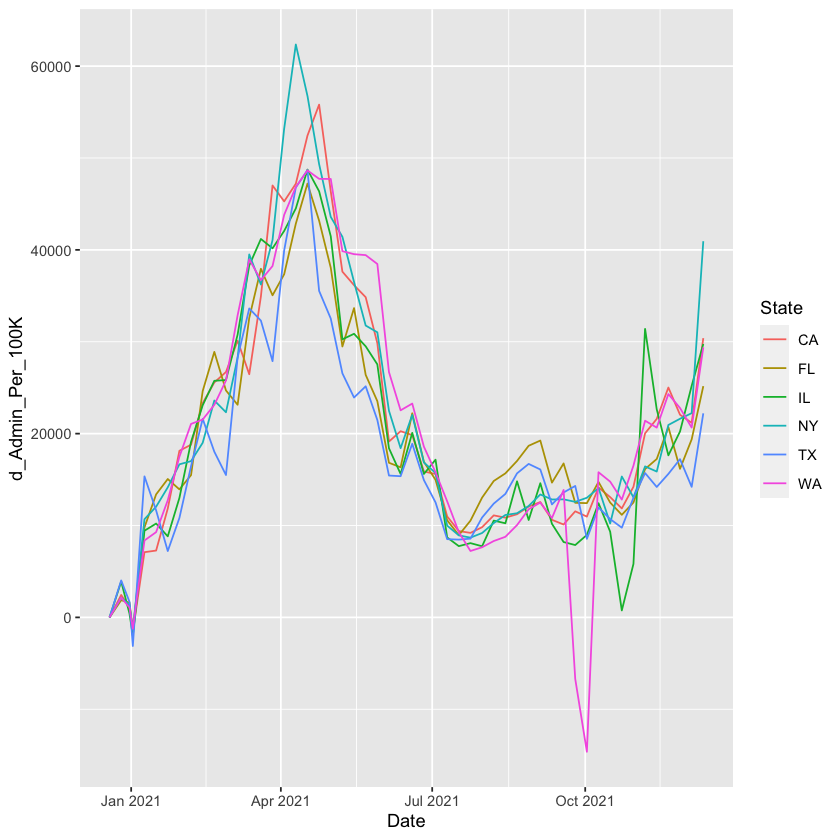

In [113]:
# Plot vaccination rates in select states
big_states = c("CA", "TX", "FL", "IL", "WA", "NY")
vacc_weekly$State = vacc_weekly$Location
a = ggplot(vacc_weekly[vacc_weekly$State %in% big_states,], aes(x=Date, y=d_Admin_Per_100K, color=State))
a + geom_line()

In [117]:
colnames(vacc_weekly)

[1] "MMWR_week"               "year"                   
 [3] "Location"                "Administered_12Plus"    
 [5] "Admin_Per_100k_12Plus"   "Administered"           
 [7] "Admin_Per_100K"          "Date"                   
 [9] "State"                   "d_Administered_12Plus"  
[11] "d_Administered"          "d_Admin_Per_100K"       
[13] "d_Admin_Per_100k_12Plus" "l_Administered_12Plus"  
[15] "l_Administered"          "l_Admin_Per_100K"       
[17] "l_Admin_Per_100k_12Plus"

In [115]:
colnames(deaths)


[1] "X"                "State"            "detrended"        "median"          
 [5] "Week.Ending.Date" "Total.Deaths"     "data_set"         "MMWR.Week"       
 [9] "centered"         "Date"

In [129]:
deaths$State = tolower(deaths$State)
deaths$Date = deaths$Week.Ending.Date
vacc_weekly$State = stateFromLower(vacc_weekly$Location)
df = merge(deaths, vacc_weekly, by = c("Date", "State"))

In [140]:
lmfit = lm(centered ~ l_Administered + d_Administered - 1, data=df)
summary(lmfit)


Call:
lm(formula = centered ~ l_Administered + d_Administered - 1, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-1908.4   -29.7    23.6   123.7  5513.1 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
l_Administered  1.221e-04  1.254e-05   9.741  < 2e-16 ***
d_Administered -3.781e-05  1.254e-05  -3.016  0.00259 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 408.5 on 2702 degrees of freedom
Multiple R-squared:  0.1854,	Adjusted R-squared:  0.1848 
F-statistic: 307.5 on 2 and 2702 DF,  p-value: < 2.2e-16


In [143]:
df$death_estimate = lmfit$fit
df$residuals = lmfit$residuals

In [166]:

pivot = pivot_longer(df, c("Total.Deaths", "death_estimate"), values_to = "Deaths", names_to="Type")
head(pivot)

Date,State,X,detrended,median,Week.Ending.Date,data_set,MMWR.Week,centered,MMWR_week,⋯,d_Administered,d_Admin_Per_100K,d_Admin_Per_100k_12Plus,l_Administered_12Plus,l_Administered,l_Admin_Per_100K,l_Admin_Per_100k_12Plus,residuals,Type,Deaths
<date>,<chr>,<int>,<dbl>,<dbl>,<date>,<chr>,<int>,<dbl>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2020-12-19,alabama,364,1482.911,1037.83544,2020-12-19,2020-2021,51,445.075949,51,⋯,0,0,0,0,72163,1472,0,436.26243,Total.Deaths,1584.000000
2020-12-19,alabama,364,1482.911,1037.83544,2020-12-19,2020-2021,51,445.075949,51,⋯,0,0,0,0,72163,1472,0,436.26243,death_estimate,8.813520
2020-12-19,alaska,781,84.000,82.19008,2020-12-19,2020-2021,51,1.809917,51,⋯,0,0,0,0,50807,6947,0,-4.39532,Total.Deaths,99.000000
2020-12-19,alaska,781,84.000,82.19008,2020-12-19,2020-2021,51,1.809917,51,⋯,0,0,0,0,50807,6947,0,-4.39532,death_estimate,6.205237
2020-12-19,arizona,1198,1909.715,1016.63084,2020-12-19,2020-2021,51,893.084112,51,⋯,0,0,0,0,93874,1289,0,881.61895,Total.Deaths,2098.000000
2020-12-19,arizona,1198,1909.715,1016.63084,2020-12-19,2020-2021,51,893.084112,51,⋯,0,0,0,0,93874,1289,0,881.61895,death_estimate,11.465161


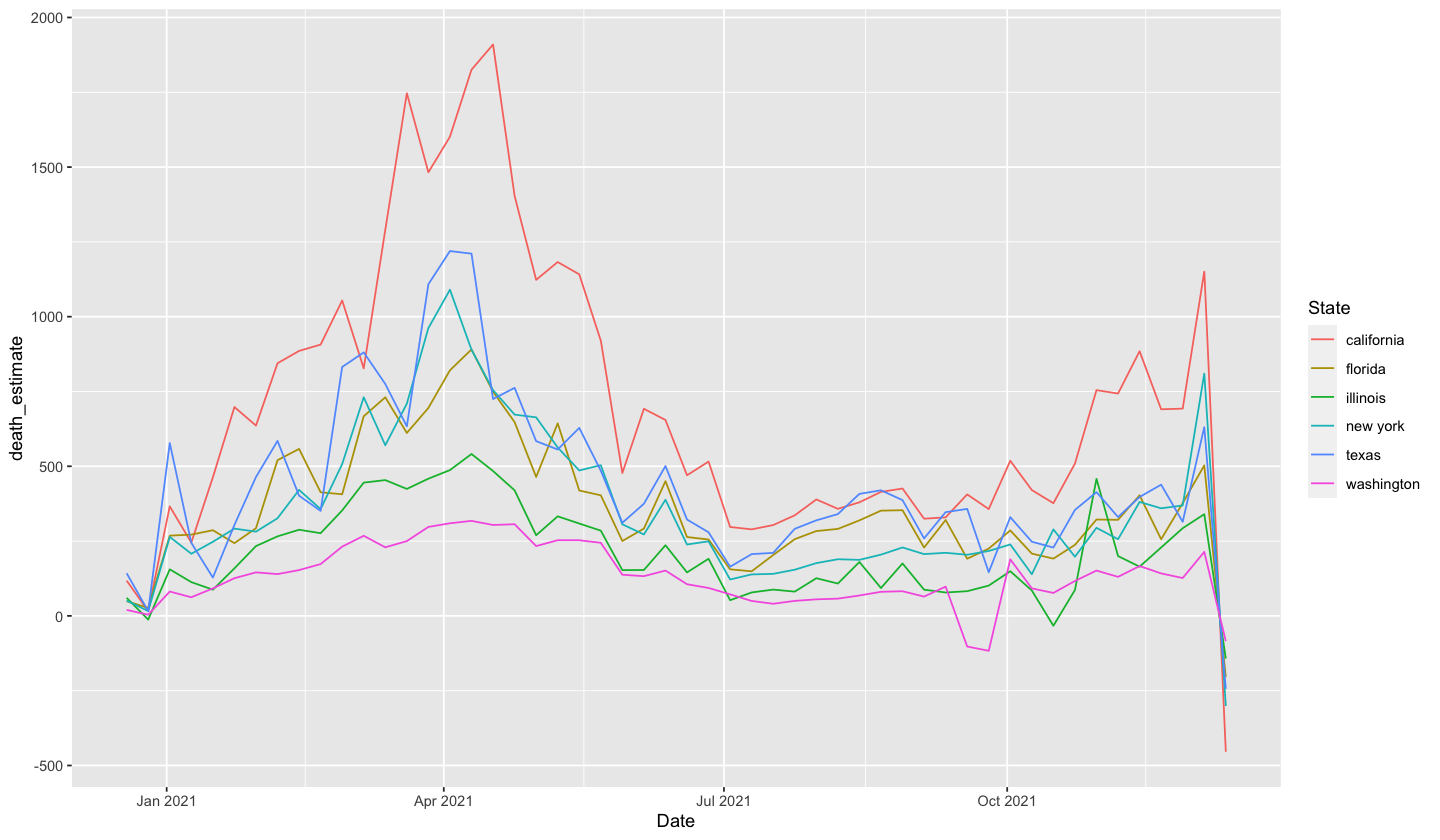

In [164]:
options(repr.plot.width=12, repr.plot.height=7)
c = ggplot(subset(df, Location %in% big_states), aes(Date, death_estimate, color=State))
c + geom_line()

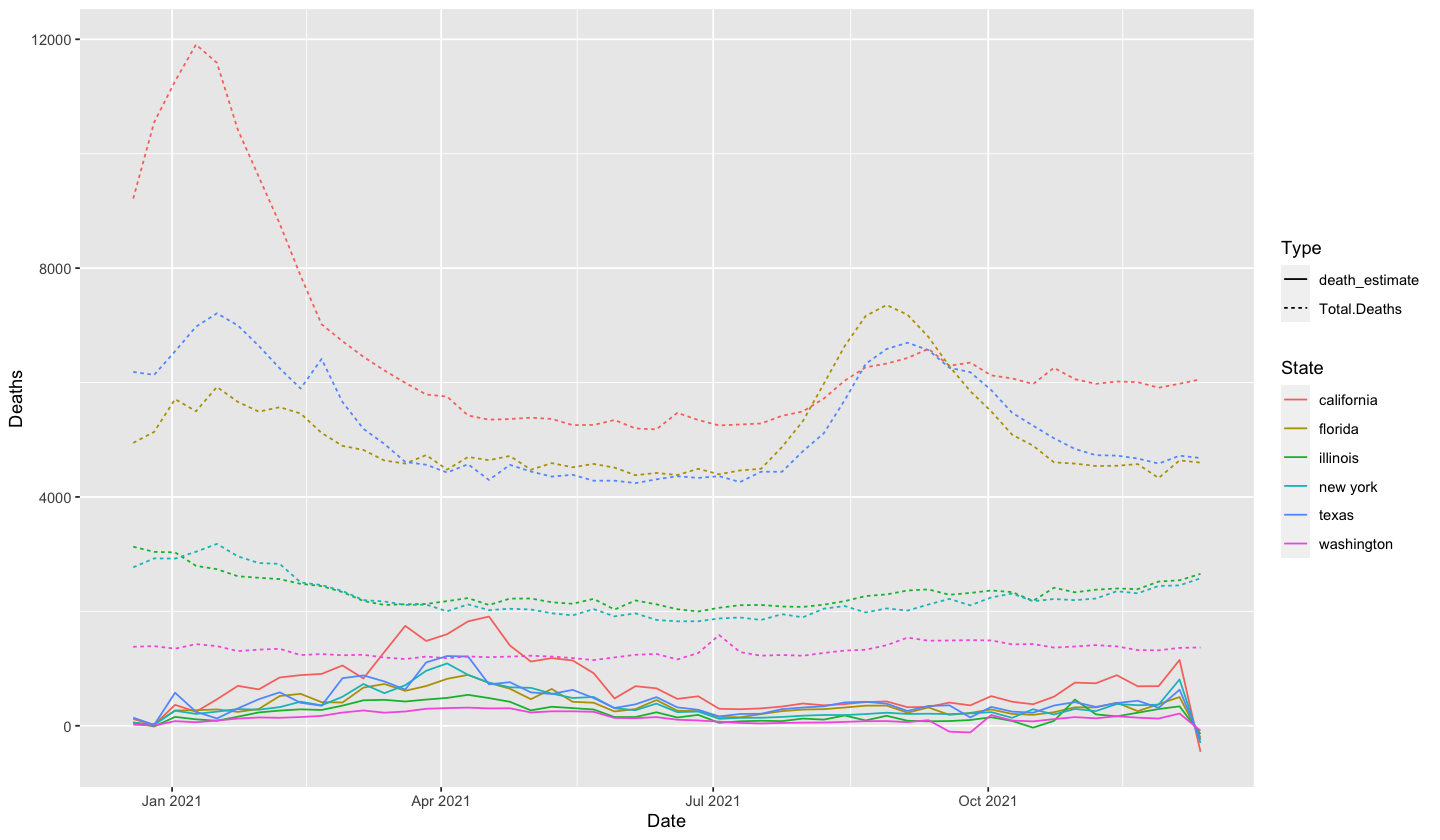

In [167]:
c = ggplot(subset(pivot, Location %in% big_states), aes(Date, Deaths, color=State))
c + geom_line(aes(linetype=Type))

In [168]:
print("overall estimated deaths from vacc week before")
sum(lmfit$fit)

[1] "overall estimated deaths from vacc week before"


[1] 279637.5

In [170]:
summary(lmfit)


Call:
lm(formula = centered ~ l_Administered + d_Administered - 1, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-1908.4   -29.7    23.6   123.7  5513.1 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
l_Administered  1.221e-04  1.254e-05   9.741  < 2e-16 ***
d_Administered -3.781e-05  1.254e-05  -3.016  0.00259 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 408.5 on 2702 degrees of freedom
Multiple R-squared:  0.1854,	Adjusted R-squared:  0.1848 
F-statistic: 307.5 on 2 and 2702 DF,  p-value: < 2.2e-16


In [145]:
help(pivot_longer)